# evalate mode projected effective energy shifts

\begin{equation}
R^{(n)}(t) \equiv \sum_{r} \Psi_n^\dagger(r) R(r, t)
\end{equation}

In [2]:
%pylab inline
import seaborn as sns
sns.set_style('ticks', {'axes.grid': True})
sns.set_context('poster', font_scale=2.0)
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (12.8, 9.6)
plt.rcParams['figure.facecolor'] = 'white'


Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle
import os

In [4]:
import scipy

import scipy.constants as sc
hbarc = ( sc.hbar * sc.speed_of_light
         / sc.mega / sc.electron_volt / sc.femto )
ainv = 2.194e3 # lattice cutoff in GeV
lat_unit = hbarc/ainv # lattice spacing in fm

mxi = 0.665 # mass of Xi in lattice unit
mpi = 510/ainv # mass of pion in lattice unit
m_red = 0.5 * mxi # reduced mass

In [5]:
bin_num = 20 # number of jackknife samples

In [6]:
print(np.__version__)
print(scipy.__version__)
print(sns.__version__)
print(matplotlib.__version__)

1.14.2
1.0.0
0.8.1
2.2.2


# import data

oritinal effective energy shifts

In [7]:
with open('../data/dEeff_xixi_1s0.pkl', 'rb') as fin:
    dEeffs = pickle.load(fin)

In [8]:
its = [10, 11, 12, 13, 14, 15, 16]

import eigenfunctions

In [9]:
eigenvals = {}
eigenfuncs_compressed = {}

In [10]:
L = 40
for it in its:
    with open('../data/eigen/eigenfuncs.40.t{}.nev50.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

In [11]:
L = 48
for it in its:
    with open('../data/eigen/eigenfuncs.48.t{}.nev75.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

In [12]:
L = 64
for it in its:
    with open('../data/eigen/eigenfuncs.64.t{}.nev100.pkl'.format(it), 'rb') as fin:
        eigenvals[(L,it)], eigenfuncs_compressed[(L,it)] = pickle.load(fin)

convert non-relativistic energies to the relativistic ones

In [13]:
conv_rela = lambda E: 2.0*np.sqrt(mxi*E + mxi**2) - 2.0*mxi
for key in eigenvals.keys():
    eigenvals[key] = conv_rela(eigenvals[key])

In [14]:
eigenval_avs = {}
eigenval_errs = {}
for it in its:
    eigenval_avs[it] = {L: eigenvals[(L,it)].mean(axis=0)
                       for L in [40, 48, 64]}
    eigenval_errs[it] = {L: eigenvals[(L,it)].std(axis=0)*np.sqrt(bin_num - 1)
                        for L in [40, 48, 64]}
    
mode_num = {40: 5, 48: 6, 64: 7}

import R-correlators

In [15]:
Rcorr_jk_compressed = {}
for L in [40, 48, 64]:
    for it in its:
        for src in ['wall', 'exp']:
            with open(f'../data/Rcorr/Rcorr_xixi_1s0_L{L}_t{it:03d}_{src}_20jkbins.pkl', 'rb') as fin:
                Rcorr_jk_compressed[(src, L, it)] = pickle.load(fin)

decompress wave functions

In [16]:
Rcorr_jk = {}
eigenfuncs = {}

In [17]:
def gen_xyz_index(L):
    a1_uniq = np.array([ix + L * (iy + L * iz)
                       for ix in range(0, L//2+1)
                       for iy in range(0, ix+1)
                       for iz in range(0, iy+1)])
    a1_uniq_ind = {}
    ind = 0
    for ix in range(0, L//2+1):
        for iy in range(0, ix+1):
            for iz in range(0, iy+1):
                a1_uniq_ind[(ix, iy, iz)] = ind
                ind += 1
    xyz_ind = {}
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                _ind = np.sort([min(ix,L-ix), min(iy,L-iy), min(iz,L-iz)])[::-1]
                xyz_ind[(ix,iy,iz)] = a1_uniq_ind[(_ind[0], _ind[1], _ind[2])]
    return xyz_ind

In [18]:
L = 40
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

In [19]:
L = 48
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

In [20]:
L = 64
xyz_ind = gen_xyz_index(L)
for src in ['wall', 'exp']:
    for it in its:
        wave_full = np.zeros((bin_num, L, L, L))
        for ix in range(L):
            for iy in range(L):
                for iz in range(L):
                    wave_full[:,ix,iy,iz] = Rcorr_jk_compressed[(src, L, it)][:,xyz_ind[(ix,iy,iz)]]
        Rcorr_jk[(src,L,it)] = wave_full.reshape(bin_num, L**3)

it0 = 13
nmodes = eigenfuncs_compressed[(L, it0)].shape[2]
for it in its:
    wave_full = np.zeros((bin_num, L, L, L, nmodes))
    for ix in range(L):
        for iy in range(L):
            for iz in range(L):
                wave_full[:,ix,iy,iz,:] = eigenfuncs_compressed[(L, it)][:,xyz_ind[(ix,iy,iz)],:]
    eigenfuncs[(L,it)] = wave_full.reshape(bin_num, L**3, nmodes)

# mode projection

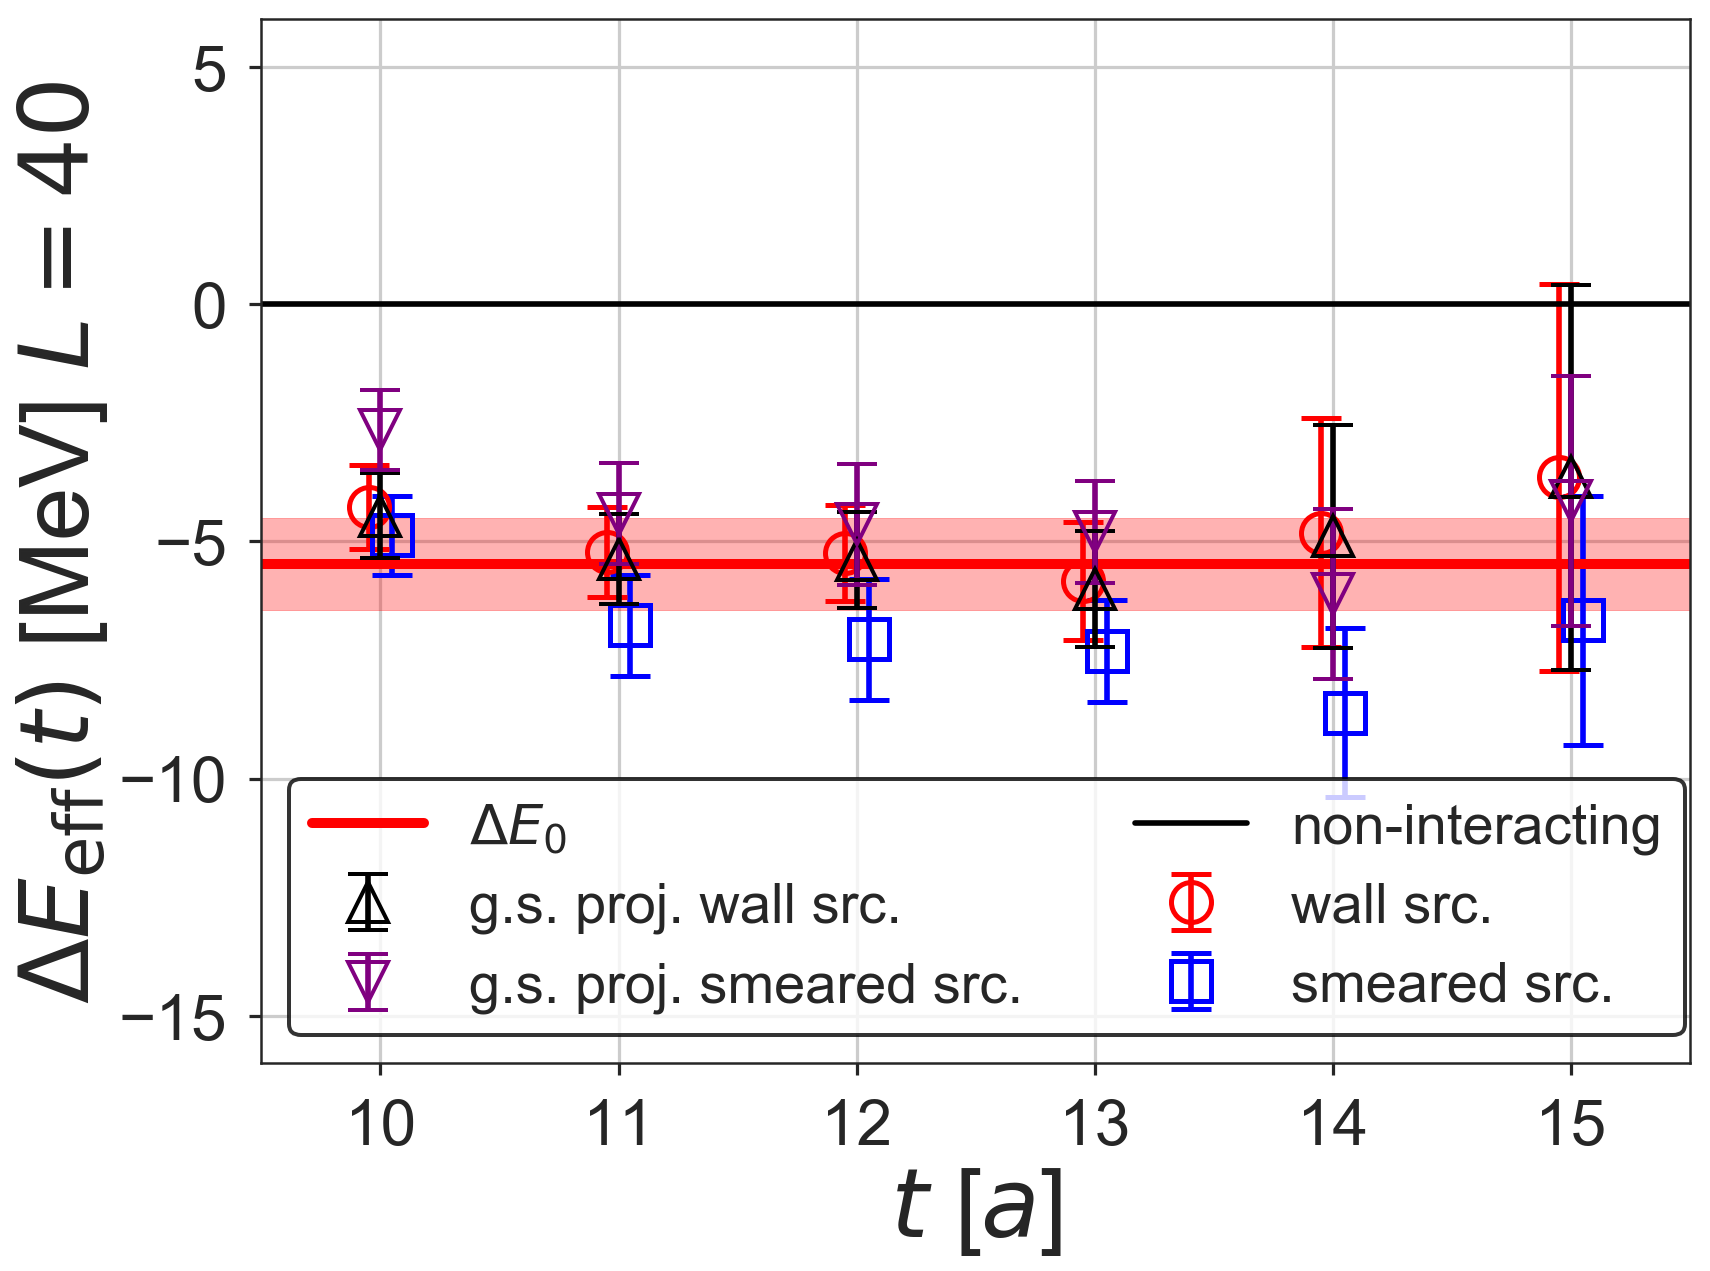

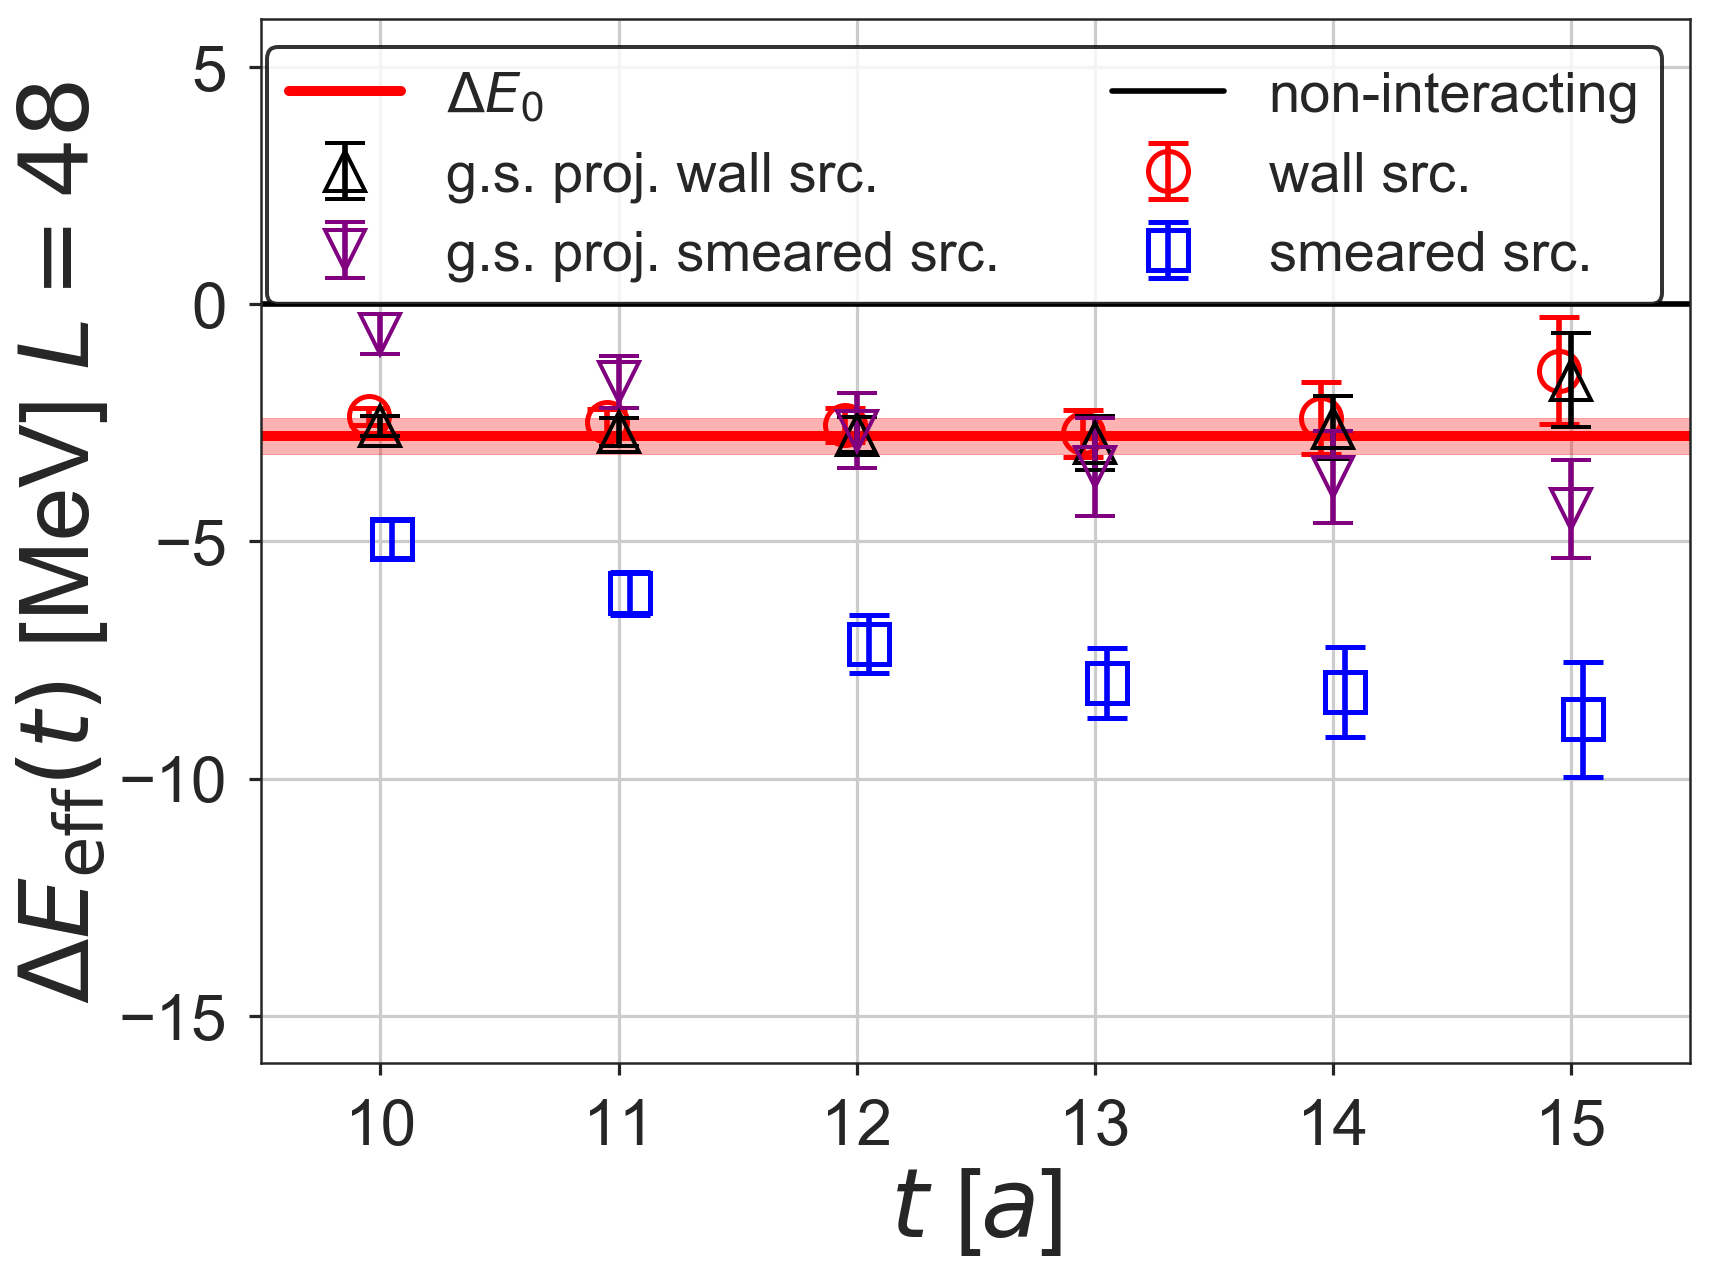

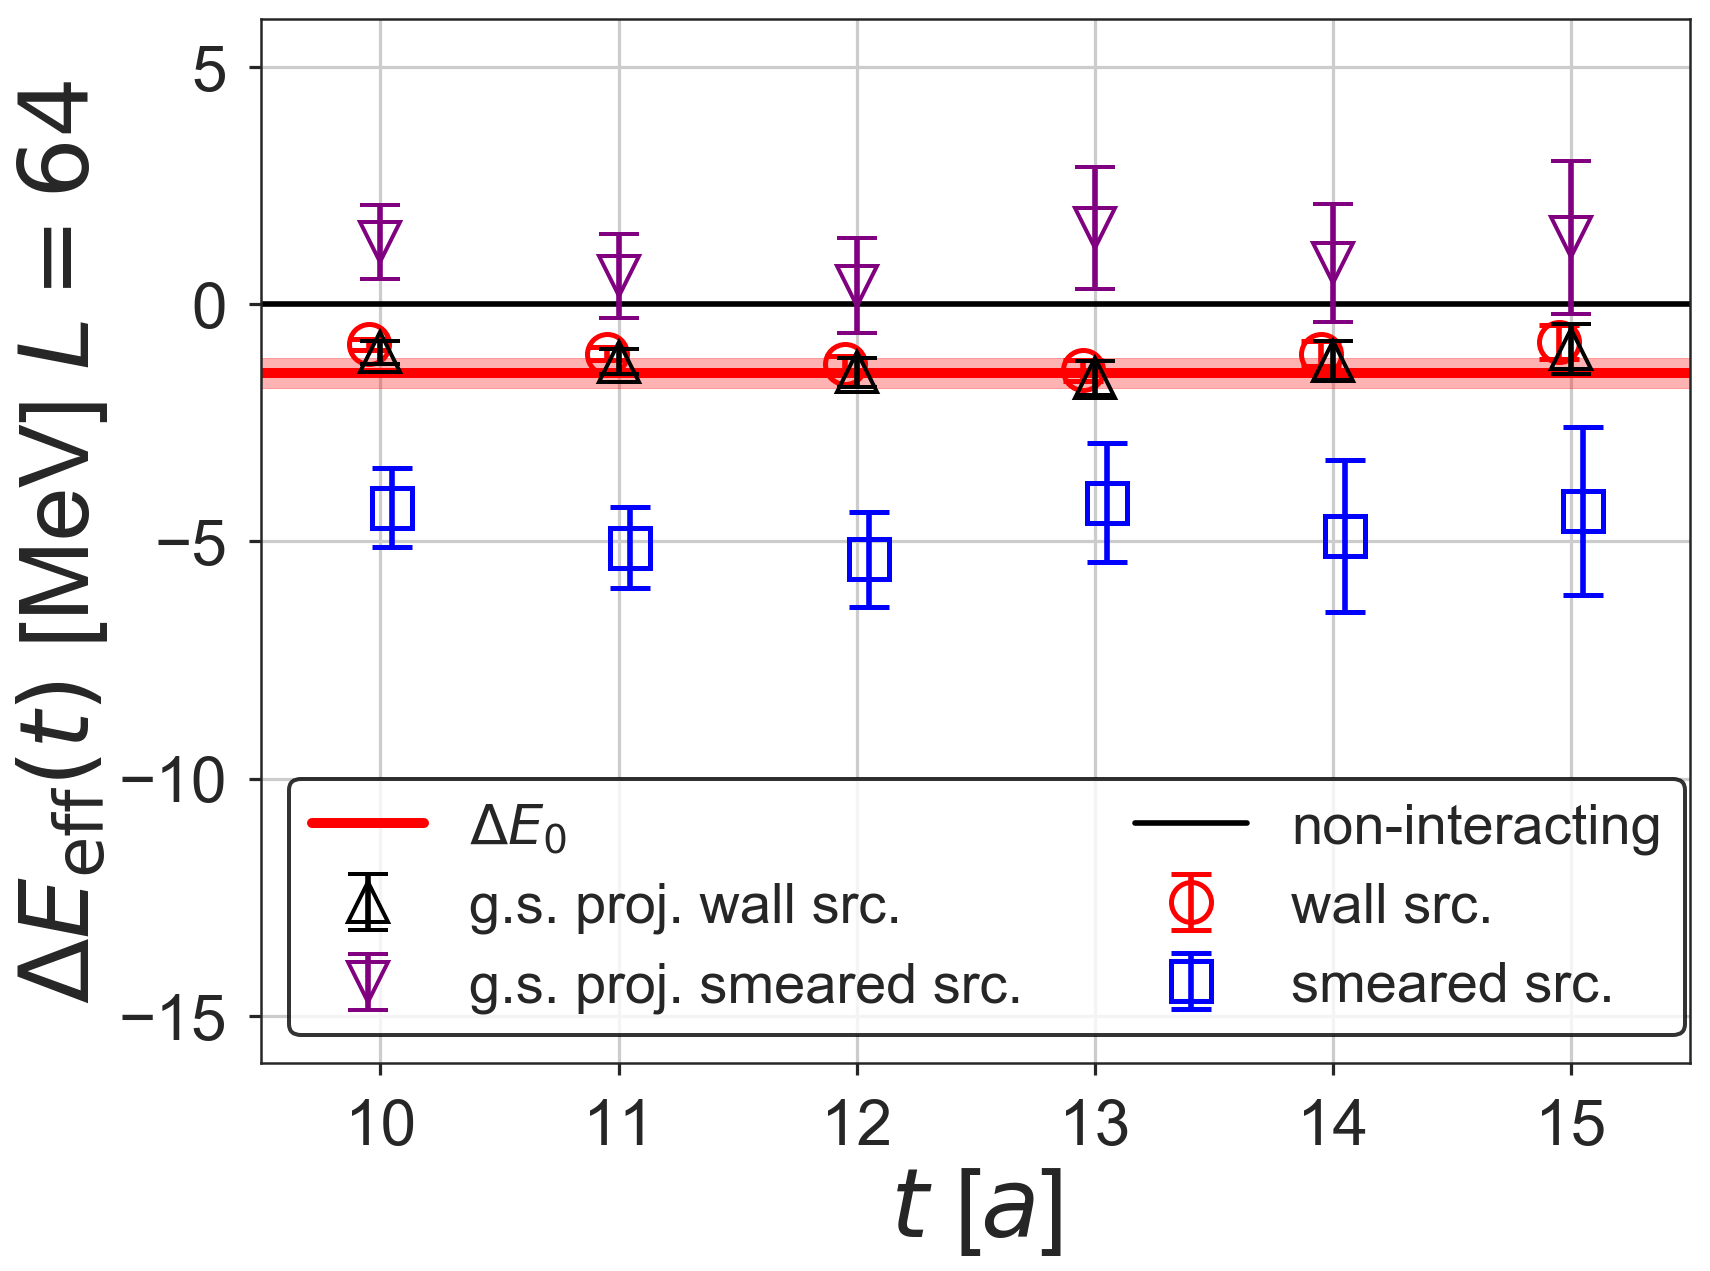

In [21]:
def mode_proj_gs(L):
    fig, ax = plt.subplots()

    its = np.array([10, 11, 12, 13, 14, 15])
    it0 = 13
    template = eigenfuncs[(L,it0)][:,:,0].mean(axis=0)
    for src, label, sym, col in zip(['wall', 'exp'], ['wall src.', 'smeared src.'],
                                    ['^', 'v'], ['black', 'purple']):
 #       _tmp_jk = np.array([np.log(
 #                           np.sum(Rcorr_jk[(src,L,it)], axis=1) / np.sum(Rcorr_jk[(src,L,it+1)], axis=1))
 #                           for it in its])
        _tmp_jk = np.array([np.log(
                           np.sum(template*Rcorr_jk[(src,L,it)], axis=1) / np.sum(template*Rcorr_jk[(src,L,it+1)], axis=1))
                           for it in its])

        ax.errorbar(its, _tmp_jk.mean(axis=1)*ainv, _tmp_jk.std(axis=1)*np.sqrt(bin_num-1)*ainv, 
                    fmt=sym, color=col, ms=20, capthick=2.0, capsize=10, mfc='none', mew=2.0, mec=col,
                   label='g.s. proj. '+label, zorder=3)
        
    ax.errorbar(dEeffs[(L,'wall')][:,0]-0.05, dEeffs[(L,'wall')][:,3]*ainv, dEeffs[(L,'wall')][:,4]*ainv,
                fmt='o', color='red', capsize=10, capthick=2.0, mfc='none', mew=2.5, mec='red', ms=20, label=rf'wall src.')
    ax.errorbar(dEeffs[(L,'exp')][:,0]+0.05, dEeffs[(L,'exp')][:,3]*ainv, dEeffs[(L,'exp')][:,4]*ainv,
                fmt='s', color='blue', capsize=10, capthick=2.0, mfc='none', mew=2.5, mec='blue', ms=20, label=rf'smeared src.')
    ax.set_ylim(-16,6)
    ax.set_xlim(9.5,15.5)
    ax.set_xlabel(r'$t$ [$a$]', size=48)
    ax.set_ylabel(r'$\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {}$'.format(L), size=48)
    ax.axhline(eigenval_avs[it0][L][0]*ainv, color='red', lw=5,
              label=r'$\Delta E_0$')
    ax.axhspan(
        (eigenval_avs[it0][L][0]+eigenval_errs[it0][L][0])*ainv, 
        (eigenval_avs[it0][L][0]-eigenval_errs[it0][L][0])*ainv, 
                       color='red', alpha=0.3)

    ax.axhline(0, color='black', label='non-interacting')

    ll, hh = ax.get_legend_handles_labels()
    ll = [ll[i] for i in [0, 2, 3, 1, 4, 5]]
    hh = [hh[i] for i in [0, 2, 3, 1, 4, 5]]
    leg = ax.legend(ll, hh, ncol=2, frameon=True, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    fig.savefig(f'../figs/dEeffs/gs_projected_L{L}.pdf', bbox_inches='tight')

for L in [40, 48, 64]:        
    mode_proj_gs(L)

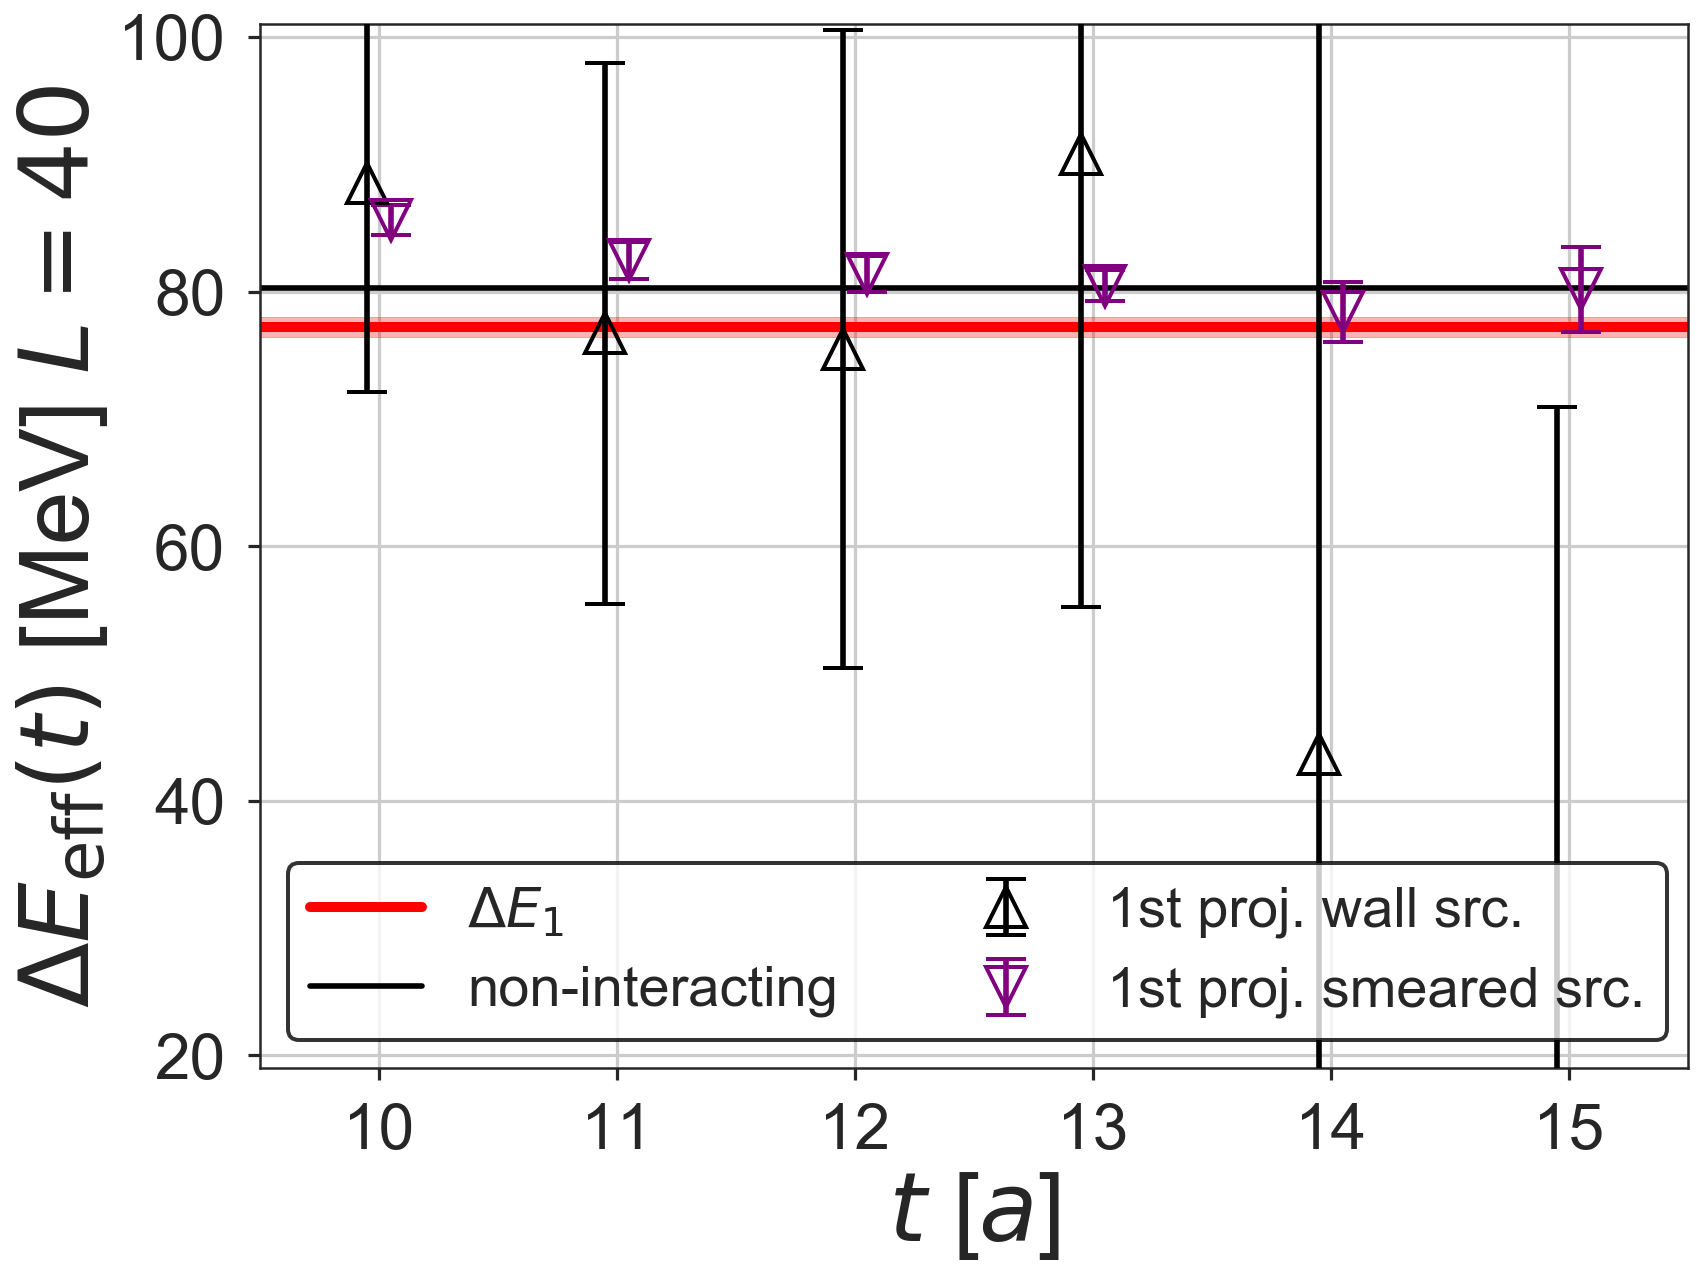

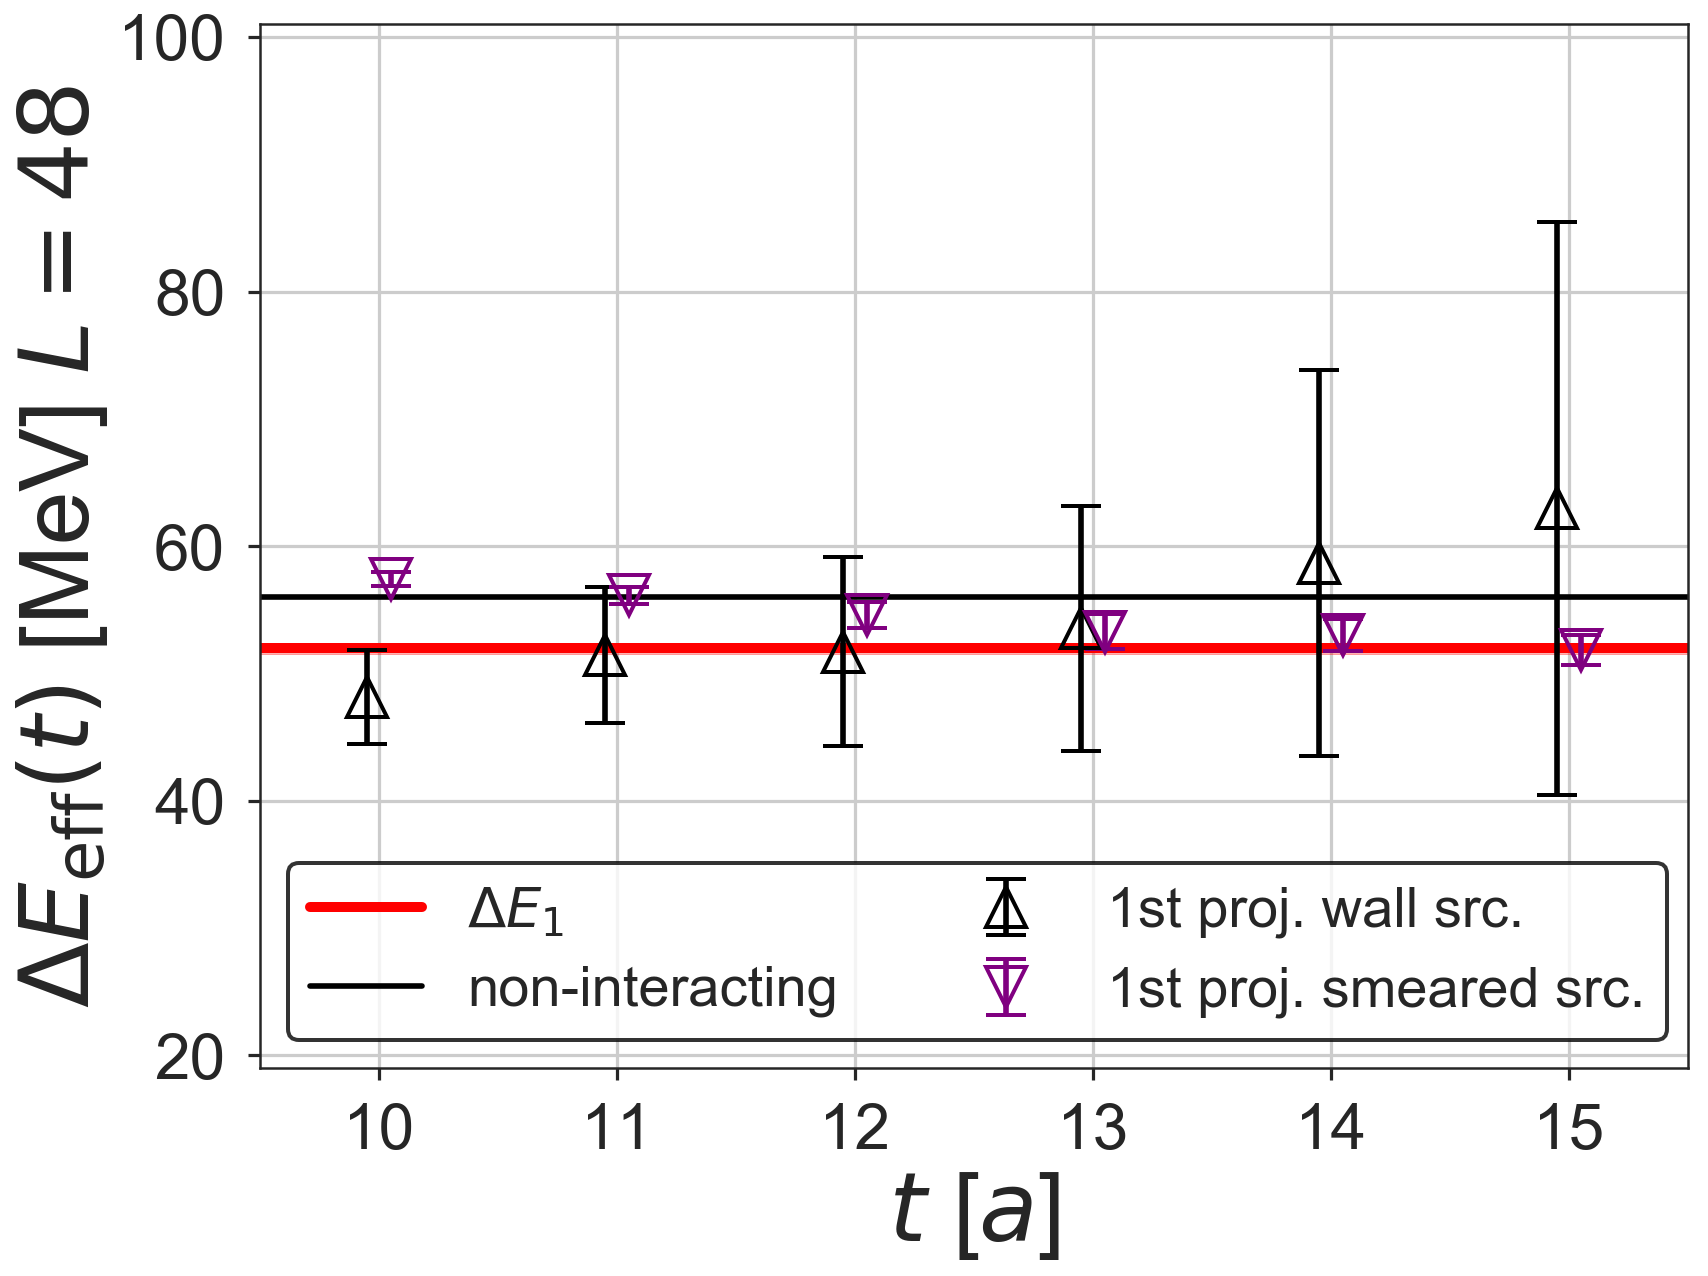

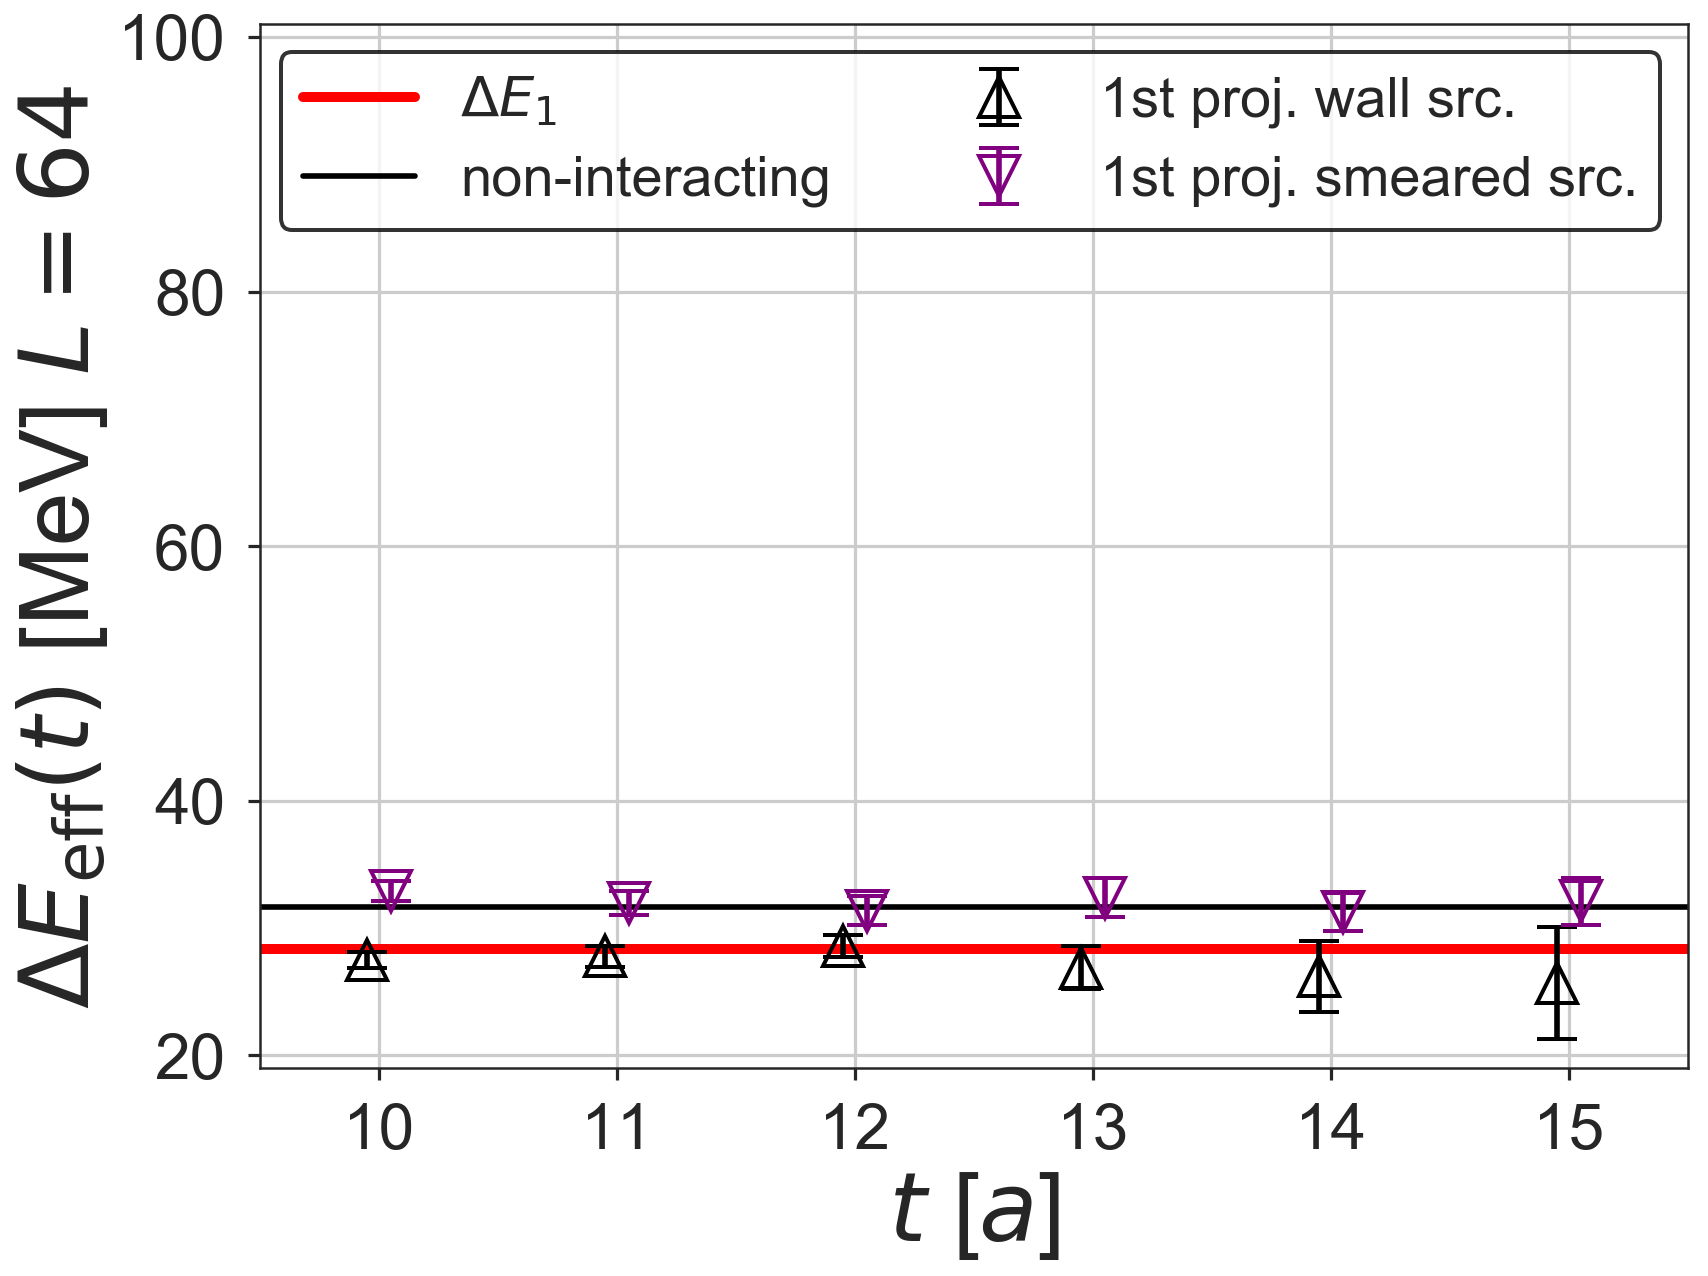

In [23]:
def mode_proj_1st(L):
    fig, ax = plt.subplots()

    its = np.array([10, 11, 12, 13, 14, 15])
    it0 = 13
    template = eigenfuncs[(L,it0)][:,:,1].mean(axis=0)
    for ss, src, label, sym, col in zip([-0.05, 0.05], ['wall', 'exp'], ['wall src.', 'smeared src.'],
                                    ['^', 'v'], ['black', 'purple']):
        _tmp_jk = np.array([np.log(
                           np.sum(template*Rcorr_jk[(src,L,it)], axis=1) / np.sum(template*Rcorr_jk[(src,L,it+1)], axis=1))
                           for it in its])

        ax.errorbar(its+ss, _tmp_jk.mean(axis=1)*ainv, _tmp_jk.std(axis=1)*np.sqrt(bin_num-1)*ainv, 
                    fmt=sym, color=col, ms=20, capthick=2.0, capsize=10, mfc='none', mew=2.0, mec=col,
                   label='1st proj. '+label, zorder=3)
        
    ax.set_ylim(19, 101)
    ax.set_xlim(9.5,15.5)
    ax.set_xlabel(r'$t$ [$a$]', size=48)
    ax.set_ylabel(r'$\Delta E_\mathrm{{eff}}(t)$ [MeV] $L = {}$'.format(L), size=48)
    ax.axhline(eigenval_avs[it0][L][1]*ainv, color='red', lw=5,
              label=r'$\Delta E_1$')
    ax.axhspan(
        (eigenval_avs[it0][L][1]+eigenval_errs[it0][L][1])*ainv, 
        (eigenval_avs[it0][L][1]-eigenval_errs[it0][L][1])*ainv, 
                       color='red', alpha=0.3)

    threshold = (2 * np.sqrt((2*np.pi/L)**2 + mxi**2) - 2*mxi)*ainv
    ax.axhline(threshold, color='black', label='non-interacting')
    ll, hh = ax.get_legend_handles_labels()
    leg = ax.legend(ll, hh, ncol=2, frameon=True, fontsize=28)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    fig.savefig(f'../figs/dEeffs/1st_projected_L{L}.pdf', bbox_inches='tight')

for L in [40, 48, 64]:        
    mode_proj_1st(L)